# Оценка рыночной стоимости автомобиля на основе исторических данных

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

______

###### Данное исследование разделено на несколько частей.

* [1. Подготовка данных.](#section1)
* [2. Обучение моделей.](#section2)
* [3. Анализ моделей](#section3)
* [4. Выводы](#section4)


<a id='section1'> </a>

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv('./datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


**Целевой признак**
* Price — цена (евро)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных выявлены следующие проблемы:
1. В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired имеются пропуски. Необходимо их заполнить или удалить часть строк.
2. В данных есть строки для которых в столбцах Price, Power или RegistrationMonth указаны нулевые значения, что является аномалией.
3. В столбце с годом регистрации автомобиля встречаются аномалии с очень низкими (min 1000) и очень высокими значениями (9999).
4. Необходимо произвести замену типов данных (в часности столбцы с датами DateCrawled, DateCreated, LastSeen необходимо привести к численным значениям).
5. В столбце NumberOfPictures все значения нулевые. Данный столбец можно удалить.


In [5]:
# убедимся что в столбце NumberOfPictures только нули
df['NumberOfPictures'].unique()

array([0], dtype=int64)

In [6]:
# удалим неинформативный столбец
df = df.drop('NumberOfPictures', axis='columns')

Посморим на распределение целевого признака в датасете.

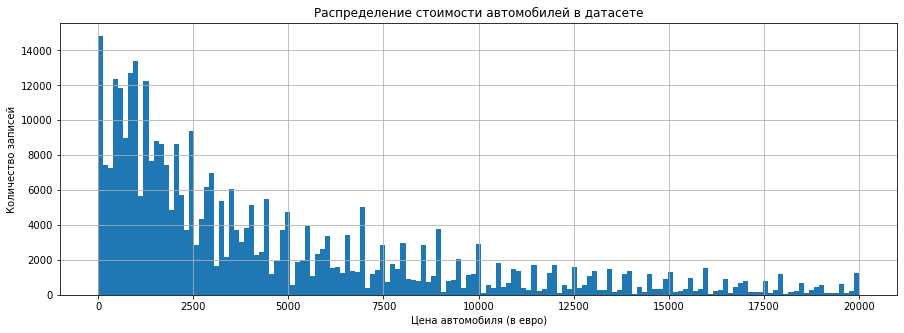

In [7]:
(df['Price'].hist(bins=151, figsize=(15,5))
     .set(xlabel='Цена автомобиля (в евро)', 
      ylabel='Количество записей',  
      title='Распределение стоимости автомобилей в датасете'));

Из линейчатости гистограммы можно сделать вывод, что люди предпочитают устанавливать "куглые" цены на автомобили. Так же на гистограмме имеется ярковыраженный пик в области нулевых цен. 

Оценим долю строк для которых указана цена автомобиля менее 100 евро.

In [8]:
len(df[df['Price']<=100]) / len(df)

0.04048040319553911

Удалим эти строки так как это явная анамалия и в рамках задачи предсказания цены на реальные автомобили данные строки не представляют интереса. Построим гистограмму повторно.

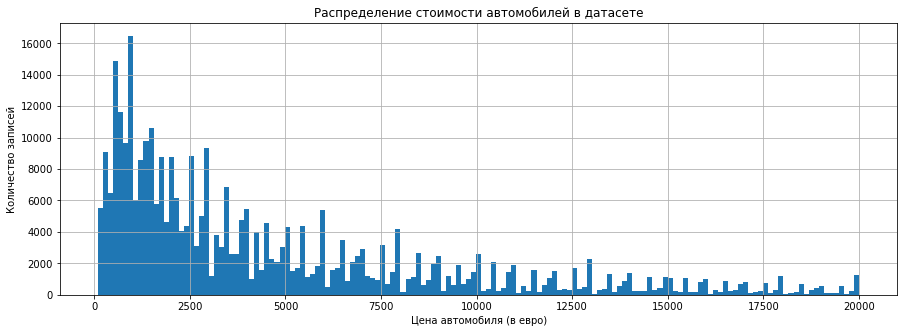

In [9]:
df = df.drop(df.index[df['Price']<=100], axis='index')

(df['Price'].hist(bins=151, figsize=(15,5))
     .set(xlabel='Цена автомобиля (в евро)', 
      ylabel='Количество записей',  
      title='Распределение стоимости автомобилей в датасете'));

Так же дополнительно создадим в датафейме колонку с округленными до 100 евро ценами на автомобили. Попробуем обучить одну из моделей на этом целевом признаке и сравним точность предсказания с моделью обученной на исходном таргете.

In [10]:
df['PriceRounded'] = (np.round(df['Price'] / 100) * 100).astype('int32')

Рассмотрим колонку с мощностью двигателя. По состоянию на 2019 г. самым мощным серийным автомобилем был электрический гиперкар Owl компании Aspark с силовой установкой порядка 2000 л.с. До 60 миль в час (97 километров в час) он разгоняется за 1,69 секунды. 

Удалим из данных все строки с мощностью двигателя более 2500 л.с, а так же с нулевой мощностью и построим гистограмму

In [11]:
df = df.drop((df.index[df['Power']>=2500]) | (df.index[df['Power']==0]), axis='index')

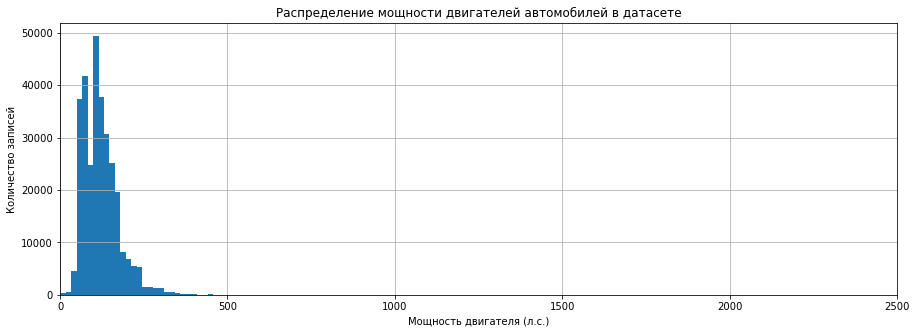

In [12]:
(df['Power'].hist(bins=151, figsize=(15,5))
.set(xlim=(0, 2500),
    xlabel='Мощность двигателя (л.с.)', 
    ylabel='Количество записей',  
    title='Распределение мощности двигателей автомобилей в датасете'));

Рассмотим распределение автомобилей по году регистрации. Ограничим свое рассмотрение только послевоенными годами (с 1945 по наст. вр.)

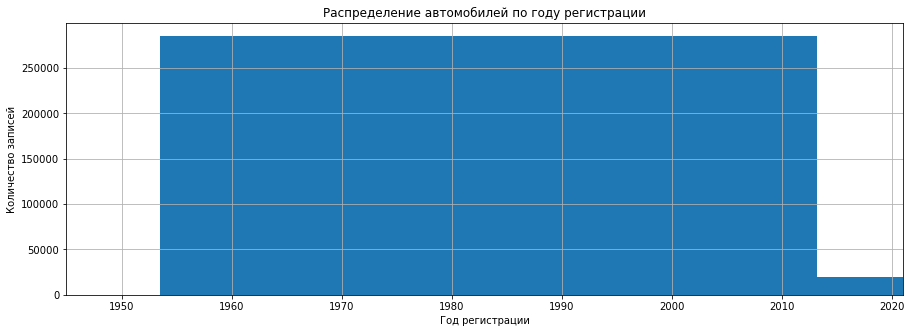

In [13]:
(df['RegistrationYear'].hist(bins=151, figsize=(15,5))
 .set(xlim=(1945, 2021),
    xlabel='Год регистрации', 
    ylabel='Количество записей',  
    title='Распределение автомобилей по году регистрации'));

Поскольку в данных встречаются аномалии с очень низкими значениями (min 1000) и очень высокими значениями (9999), то гистограмма оказалась искаженной. Удалим строки не относящиеся к рассматриваемому периоду и построим гистограмму повторно.

In [14]:
df = df.drop(df.index[(df['RegistrationYear']<=1945) | (df['RegistrationYear']>=2021)], axis='index')

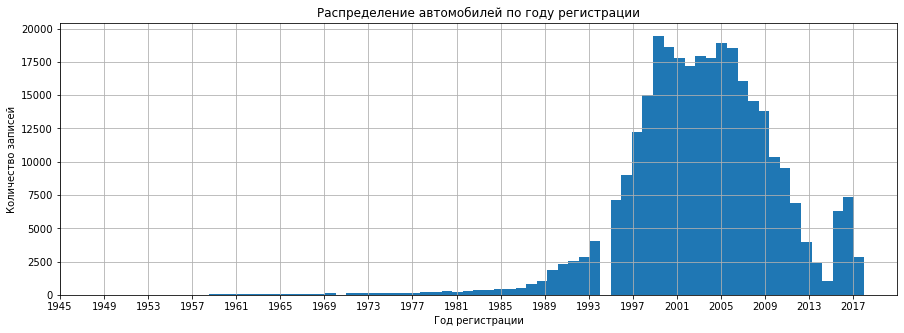

In [15]:
(df['RegistrationYear'].hist(bins=75, figsize=(15,5))
 .set(xlim=(1945, 2021),
    xticks=[x for x in range(1945,2021,4)],
    xlabel='Год регистрации', 
    ylabel='Количество записей',  
    title='Распределение автомобилей по году регистрации'));

По гистограмме видно, что значительное снижение регистрации автомобилей произошло после кризиса 2008-2009 годов, а восстановление рынка началось только в 2015 году.

Посмотрим на уникальные значения которые встречаются в столбце RegistrationMonth

In [16]:
df['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Столбец содержит 13 уникальных значений. Удалим строки для которых указан нулевой месяц регистрации.

In [17]:
df = df.drop(df.index[df['RegistrationMonth']==0], axis='index')
df['RegistrationMonth'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

В столбцах NotRepaired, FuelType, VehicleType, Gearbox, Model незаполненные значения заполним значением 'unknown'

In [18]:
df['NotRepaired'].unique()

array(['yes', nan, 'no'], dtype=object)

In [19]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')
df['NotRepaired'].unique()

array(['yes', 'unknown', 'no'], dtype=object)

In [20]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [21]:
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'].unique()

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [22]:
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [23]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [24]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [25]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [26]:
df['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'other', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'astra', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'escort', 'forester', 'xc_reihe', 'scenic', 'a1',
       'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er',
       'combo', '80', '147', 'z_reihe', 'sportage', 'sorento', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'insignia', 'ka', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'mondeo', 'cordoba', 'colt',
       'corsa', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'panda', 'up',
       'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia',
       'zafira', 'mii', 'rx_reihe', '6er', 'fox', 'matiz', 'beetle',
       'rio', 'touareg', 'logan', 'caddy', 'spider', 'cuore', 's_max',
       'modus', '

In [27]:
df['Model'] = df['Model'].fillna('unknown')

Убедимся что данные больше не содержат строк с незаполненными значениями.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285659 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        285659 non-null  object
 1   Price              285659 non-null  int64 
 2   VehicleType        285659 non-null  object
 3   RegistrationYear   285659 non-null  int64 
 4   Gearbox            285659 non-null  object
 5   Power              285659 non-null  int64 
 6   Model              285659 non-null  object
 7   Kilometer          285659 non-null  int64 
 8   RegistrationMonth  285659 non-null  int64 
 9   FuelType           285659 non-null  object
 10  Brand              285659 non-null  object
 11  NotRepaired        285659 non-null  object
 12  DateCreated        285659 non-null  object
 13  PostalCode         285659 non-null  int64 
 14  LastSeen           285659 non-null  object
 15  PriceRounded       285659 non-null  int32 
dtypes: int32(1), int64(6

Преобразуем данные с датами к численным значениям.

In [29]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S').astype('int64') / 10**9
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S').astype('int64') / 10**9
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S').astype('int64') / 10**9

Выведем текущие типы данных в датафрейме в виде словаря.

In [30]:
df.dtypes.apply(lambda x: x.name).to_dict()

{'DateCrawled': 'float64',
 'Price': 'int64',
 'VehicleType': 'object',
 'RegistrationYear': 'int64',
 'Gearbox': 'object',
 'Power': 'int64',
 'Model': 'object',
 'Kilometer': 'int64',
 'RegistrationMonth': 'int64',
 'FuelType': 'object',
 'Brand': 'object',
 'NotRepaired': 'object',
 'DateCreated': 'float64',
 'PostalCode': 'int64',
 'LastSeen': 'float64',
 'PriceRounded': 'int32'}

In [31]:
# заменим типы в таблице по словарю df_type_dict
df_type_dict = {'DateCrawled': 'float64',
 'Price': 'int32',
 'VehicleType': 'category',
 'RegistrationYear': 'uint16',
 'Gearbox': 'category',
 'Power': 'uint16',
 'Model': 'category',
 'Kilometer': 'int32',
 'RegistrationMonth': 'uint8',
 'FuelType': 'category',
 'Brand': 'category',
 'NotRepaired': 'category',
 'DateCreated': 'float64',
 'PostalCode': 'int32',
 'LastSeen': 'float64',
 'PriceRounded': 'int32'}

df = df.astype(df_type_dict)

# убедимся что замена прошла так как задумано
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285659 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DateCrawled        285659 non-null  float64 
 1   Price              285659 non-null  int32   
 2   VehicleType        285659 non-null  category
 3   RegistrationYear   285659 non-null  uint16  
 4   Gearbox            285659 non-null  category
 5   Power              285659 non-null  uint16  
 6   Model              285659 non-null  category
 7   Kilometer          285659 non-null  int32   
 8   RegistrationMonth  285659 non-null  uint8   
 9   FuelType           285659 non-null  category
 10  Brand              285659 non-null  category
 11  NotRepaired        285659 non-null  category
 12  DateCreated        285659 non-null  float64 
 13  PostalCode         285659 non-null  int32   
 14  LastSeen           285659 non-null  float64 
 15  PriceRounded       285659 non-null

Данные подготовлены, теперь можно переходить к обучению моделей

<a id='section2'> </a>

# 2. Обучение моделей

Создадим списки с названиями целевой переменной и фич, затем разделим выборку на тестовую, тренировачную и валидационную

In [32]:
y_col = ['Price']
x_col = df.columns.drop(y_col + ['PriceRounded'])
x_col

Index(['DateCrawled', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power',
       'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [33]:
train_full, test = train_test_split(df, test_size=0.2, random_state=42)

In [34]:
len(train_full)

228527

In [35]:
len(test)

57132

In [36]:
# проверим соответствие длин датафреймов
len(train_full) + len(test) == len(df)

True

In [37]:
train, val = train_test_split(train_full, test_size=0.2, random_state=42)

In [38]:
len(train) + len(val) == len(train_full)

True

### LightGBM

In [39]:
%%time

lgbm_model = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, random_state=42)

lgbm_model.fit(train[x_col], train[y_col], 
               eval_set=(val[x_col], val[y_col]), 
               verbose=50)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	valid_0's rmse: 1656.37
[100]	valid_0's rmse: 1587.84
[150]	valid_0's rmse: 1563.98
[200]	valid_0's rmse: 1553.73
[250]	valid_0's rmse: 1543.26
[300]	valid_0's rmse: 1535.75
[350]	valid_0's rmse: 1529.6
[400]	valid_0's rmse: 1524.99
[450]	valid_0's rmse: 1520.54
[500]	valid_0's rmse: 1518.99
[550]	valid_0's rmse: 1516.69
[600]	valid_0's rmse: 1514.97
[650]	valid_0's rmse: 1513
[700]	valid_0's rmse: 1512.15
[750]	valid_0's rmse: 1509.63
[800]	valid_0's rmse: 1506.83
[850]	valid_0's rmse: 1503.99
[900]	valid_0's rmse: 1501.84
[950]	valid_0's rmse: 1501.05
[1000]	valid_0's rmse: 1499.61
Wall time: 8.1 s


LGBMRegressor(metric='rmse', n_estimators=1000, random_state=42)

In [40]:
%%time
lgbm_val_predict = lgbm_model.predict(val[x_col])

Wall time: 886 ms


In [41]:
lgbm_val_score = np.sqrt(mean_squared_error(val[y_col], lgbm_val_predict))
print('СКО на валидационной выборке:', lgbm_val_score)

СКО на валидационной выборке: 1499.6062994611098


In [42]:
%%time
lgbm_test_predict = lgbm_model.predict(test[x_col])

Wall time: 1.33 s


In [43]:
lgbm_test_score = np.sqrt(mean_squared_error(test[y_col], lgbm_test_predict))
print('СКО на тестовой выборке:', lgbm_test_score)

СКО на тестовой выборке: 1508.6777304071622


Попробуем обучить моделель на этом целевом признаке с округлением до 100 евро и сравним точность предсказания с моделью обученной на исходном таргете.

In [44]:
%%time

lgbm_model_rounded = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, random_state=42)

lgbm_model_rounded.fit(train[x_col], train['PriceRounded'].values, 
                       eval_set=(val[x_col], val['PriceRounded'].values), 
                       verbose=50)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	valid_0's rmse: 1657.96
[100]	valid_0's rmse: 1588.23
[150]	valid_0's rmse: 1566.38
[200]	valid_0's rmse: 1552.52
[250]	valid_0's rmse: 1543.01
[300]	valid_0's rmse: 1537.36
[350]	valid_0's rmse: 1529.06
[400]	valid_0's rmse: 1522.72
[450]	valid_0's rmse: 1520.01
[500]	valid_0's rmse: 1517.81
[550]	valid_0's rmse: 1514.51
[600]	valid_0's rmse: 1511.86
[650]	valid_0's rmse: 1510.13
[700]	valid_0's rmse: 1508.65
[750]	valid_0's rmse: 1506.71
[800]	valid_0's rmse: 1504.86
[850]	valid_0's rmse: 1502.54
[900]	valid_0's rmse: 1499.64
[950]	valid_0's rmse: 1498.53
[1000]	valid_0's rmse: 1497.69
Wall time: 8.5 s


LGBMRegressor(metric='rmse', n_estimators=1000, random_state=42)

In [45]:
print('СКО на тестовой выборке:', np.sqrt(mean_squared_error(test[y_col], lgbm_model_rounded.predict(test[x_col]))))

СКО на тестовой выборке: 1505.8263151962294


Обе модели дают близкое СКО на тестовых данных. Округление таргета не дает существенного прироста качества модели.

### CatBoost

In [46]:
%%time
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
train_pool = Pool(train[x_col], train[y_col], cat_features=cat_features)
val_pool = Pool(val[x_col], val[y_col], cat_features=cat_features)

Wall time: 357 ms


In [47]:
%%time
cb_model = CatBoostRegressor(loss_function='RMSE', 
                             eval_metric='RMSE', 
                             random_state=42, 
                             verbose=50, 
                             learning_rate=0.52)

cb_model.fit(train_pool, eval_set=[val_pool])

0:	learn: 3235.2441072	test: 3229.3219208	best: 3229.3219208 (0)	total: 374ms	remaining: 6m 13s
50:	learn: 1668.0416248	test: 1669.6942563	best: 1669.6942563 (50)	total: 12.9s	remaining: 3m 59s
100:	learn: 1584.7931146	test: 1615.7852191	best: 1615.7852191 (100)	total: 24.7s	remaining: 3m 39s
150:	learn: 1540.8652099	test: 1594.2873308	best: 1594.2873308 (150)	total: 40.4s	remaining: 3m 46s
200:	learn: 1503.9518624	test: 1580.7199787	best: 1580.7199787 (200)	total: 56.5s	remaining: 3m 44s
250:	learn: 1479.6082262	test: 1572.5372098	best: 1572.2537195 (245)	total: 1m 14s	remaining: 3m 42s
300:	learn: 1455.7065183	test: 1566.5983742	best: 1566.5352951 (299)	total: 1m 30s	remaining: 3m 29s
350:	learn: 1434.4543714	test: 1562.5096511	best: 1562.1051065 (345)	total: 1m 45s	remaining: 3m 15s
400:	learn: 1418.7824402	test: 1560.4027926	best: 1560.3424897 (399)	total: 2m 1s	remaining: 3m 2s
450:	learn: 1402.2310150	test: 1557.9764977	best: 1557.8219511 (448)	total: 2m 16s	remaining: 2m 46s
500

In [48]:
%%time
cb_val_predict = cb_model.predict(val[x_col])

Wall time: 603 ms


In [49]:
cb_val_score = np.sqrt(mean_squared_error(val[y_col], cb_val_predict))
print('СКО на валидационной выборке:', cb_val_score)

СКО на валидационной выборке: 1542.894717262558


In [50]:
%%time
cb_test_predict = cb_model.predict(test[x_col])

Wall time: 651 ms


In [51]:
cb_test_score = np.sqrt(mean_squared_error(test[y_col], cb_test_predict))
print('СКО на тестовой выборке:', cb_test_score)

СКО на тестовой выборке: 1547.074728750629


### Линейная регрессия

Прежде чем применять линейные алгоритмы необходимо отмасштабировать числовые признаки

In [52]:
num_col = x_col.drop(cat_features)
num_col

Index(['DateCrawled', 'RegistrationYear', 'Power', 'Kilometer',
       'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [53]:
scaler = StandardScaler()
scaler.fit(train[num_col])

StandardScaler()

In [54]:
train_scaled = train.copy()
train_scaled[num_col] = scaler.transform(train_scaled[num_col])
val_scaled = val.copy()
val_scaled[num_col] = scaler.transform(val_scaled[num_col])
test_scaled = test.copy()
test_scaled[num_col] = scaler.transform(test_scaled[num_col])

Так же заменим категориальные переменные используя технику OHE

In [55]:
train_scaled = pd.get_dummies(train_scaled, drop_first=True)
val_scaled = pd.get_dummies(val_scaled, drop_first=True)
test_scaled = pd.get_dummies(test_scaled, drop_first=True)

In [56]:
x_col_lr = train_scaled.columns.drop(y_col + ['PriceRounded'])
x_col_lr

Index(['DateCrawled', 'RegistrationYear', 'Power', 'Kilometer',
       'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen',
       'VehicleType_convertible', 'VehicleType_coupe',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_unknown', 'NotRepaired_yes'],
      dtype='object', length=314)

In [57]:
%%time
lr_model = LinearRegression()
lr_model.fit(train_scaled[x_col_lr], train_scaled[y_col])

Wall time: 7.13 s


LinearRegression()

In [58]:
%%time
lr_val_predict = lr_model.predict(val_scaled[x_col_lr])

Wall time: 291 ms


In [59]:
lr_val_score = np.sqrt(mean_squared_error(val_scaled[y_col], lr_val_predict))
print('СКО на валидационной выборке:', lr_val_score)

СКО на валидационной выборке: 2657.5034527678285


In [60]:
%%time
lr_test_predict = lr_model.predict(test_scaled[x_col_lr])

Wall time: 328 ms


In [61]:
lr_test_score = np.sqrt(mean_squared_error(test_scaled[y_col], lr_test_predict))
print('СКО на тестовой выборке:', lr_test_score)

СКО на тестовой выборке: 2673.4885190817163


### K ближайших соседей

In [62]:
%%time
knn_model = KNeighborsRegressor()
knn_model.fit(train_scaled[x_col_lr], train_scaled[y_col])

Wall time: 1min 25s


KNeighborsRegressor()

In [63]:
%%time
knn_val_predict = knn_model.predict(val_scaled[x_col_lr])

Wall time: 11min 44s


In [64]:
knn_val_score = np.sqrt(mean_squared_error(val_scaled[y_col], knn_val_predict))
print('СКО на валидационной выборке:', knn_val_score)

СКО на валидационной выборке: 2118.345495244401


In [65]:
%%time
knn_test_predict = knn_model.predict(test_scaled[x_col_lr])

Wall time: 16min 9s


In [66]:
knn_test_score = np.sqrt(mean_squared_error(test_scaled[y_col], knn_test_predict))
print('СКО на тестовой выборке:', lr_test_score)

СКО на тестовой выборке: 2673.4885190817163


<a id='section3'> </a>

# 3. Анализ моделей

Составим сводную таблицу на осове данных полученых в процессе обучения

In [67]:
pd.DataFrame({'Модель': ['LightGBM', 'CatBoost', 'Линейная регрессия', 'K ближайших соседей'],
'СКО оценки стоимости на валидационной выборке, евро': [lgbm_val_score, cb_val_score, lr_val_score, knn_val_score],
'СКО оценки стоимости на тестовой выборке, евро': [lgbm_test_score, cb_test_score, lr_test_score, knn_test_score], 
'Время обучения модели': ['1min 5s', '12min 28s', '20.8 s', '11.3 s'],
'Время вычисления предсказаний на валидационной выборке': ['5.99 s', '918 ms', '144 ms', '14min 35s'],
'Время вычисления предсказаний на тестовой выборке': ['7.43 s', '1.27 s', '115 ms', '19min 51s'],
})

,Модель,"СКО оценки стоимости на валидационной выборке, евро","СКО оценки стоимости на тестовой выборке, евро",Время обучения модели,Время вычисления предсказаний на валидационной выборке,Время вычисления предсказаний на тестовой выборке
0,LightGBM,1499.606299,1508.677730,1min 5s,5.99 s,7.43 s
1,CatBoost,1542.894717,1547.074729,12min 28s,918 ms,1.27 s
2,Линейная регрессия,2657.503453,2673.488519,20.8 s,144 ms,115 ms
3,K ближайших соседей,2118.345495,2129.361396,11.3 s,14min 35s,19min 51s


Наибольшей точностью оценки стоимости автомобилей по предоставленным данным обладает модель LightGBM (СКО ~1505 евро). Близкой по точности является модель CatBoost (СКО ~1552 евро). При этом CatBoost формирует предсказания примерно в 6 раз быстрее, чем LightGBM (порядка 1 с против 6 с у LightGBM). Недостатком CatBoost является большее время на обучение модели (12 мин против 1 мин у LightGBM).

<a id='section4'> </a>

# Выводы

В процессе исследования были выполнены следующие работы:
1. Проведена подготовка данных (устранены аномалии, заполнены пропуски)
2. Обучено несколько моделей прогнозирования цены на автомобили. Рассмотренные модели:
    * LightGBM
    * CatBoost
    * Линейная регрессия
    * K ближайших соседей
3. Проведен анализ эффективности моделей

Наибольшей точностью оценки стоимости автомобилей по предоставленным данным обладает модель LightGBM (СКО 1505 евро). При этом в случае, если для пользователей небходимо предсказывать цену в режиме близком к реальному времени, рекумендуется использовать модель CatBoost. Данная модель дает близкое СКО (~1552 евро), но существенный выйгрыш по времени предсказания. В случае если скорость обучения модели важнее скорости предсказания, рекомендуется использовать модель LightGBM.